In [19]:
from regen.classification import NCA3D, load_weights_from_classification_file
from regen.utils import plot_voxels
import torch
import numpy as np
import re
import torch.nn as nn

In [92]:
import torch
import torch.nn as nn
import numpy as np

class NCA3D(nn.Module):
    def __init__(
        self,
        num_hidden_channels: int = 20,
        num_classes: int = 7,
        alpha_living_threshold: float = 0.1,
        cell_fire_rate: float = 0.5,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_hidden_channels = num_hidden_channels
        self.alpha_living_threshold = alpha_living_threshold
        self.cell_fire_rate = cell_fire_rate

        self.channel_n = num_hidden_channels + num_classes + 1  # 28
        self.perception_channels = self.channel_n * 3  # 84
        
        # Define the 3D kernel mask
        self.kernel_mask = torch.tensor(
            [[[0, 0, 0],
              [0, 1, 0],
              [0, 0, 0]],

             [[0, 1, 0],
              [1, 1, 1],
              [0, 1, 0]],

             [[0, 0, 0],
              [0, 1, 0],
              [0, 0, 0]],
             ], dtype=torch.float32
        )

        # Perception network: 28 → 84 channels
        self.perceive = nn.Sequential(
            nn.Conv3d(
                self.channel_n, self.perception_channels, kernel_size=3, padding=1
            ),  # 28 → 84
            nn.ReLU(),
        )

        # Dense model: 84 → 84 → 27
        self.dmodel = nn.Sequential(
            nn.Conv3d(self.perception_channels, self.perception_channels, kernel_size=1),  # 84 → 84
            nn.ReLU(),
            nn.Conv3d(self.perception_channels, self.channel_n - 1, kernel_size=1),  # 84 → 27
        )

        # Initialize the second dmodel layer with zeros (like TensorFlow version)
        nn.init.zeros_(self.dmodel[2].weight)
        nn.init.zeros_(self.dmodel[2].bias)

    def reset_diag_kernel(self):
        # Apply the kernel mask to the perception layer's weights
        conv_layer = self.perceive[0]
        kernel_mask = self.kernel_mask.to(conv_layer.weight.device)
        
        # Expand mask to match weight dimensions [out_channels, in_channels, depth, height, width]
        kernel_mask = kernel_mask.repeat(conv_layer.out_channels, conv_layer.in_channels, 1, 1, 1)
        conv_layer.weight.data *= kernel_mask

    def forward(self, x):
        # Split input into gray and state channels
        gray, state = torch.split(x, [1, self.channel_n - 1], dim=-1)

        # Permute for Conv3d (batch, channels, depth, height, width)
        x_permuted = x.permute(0, 4, 1, 2, 3)  # 28 channels

        # Process through perception (28 → 84) and dmodel (84 → 84 → 27)
        perceived = self.perceive(x_permuted)
        update = self.dmodel(perceived)

        # Permute back to (batch, depth, height, width, channels)
        update = update.permute(0, 2, 3, 4, 1)  # 27 channels

        # Create update mask based on cell fire rate
        update_mask = torch.rand_like(gray) <= self.cell_fire_rate
        living_mask = gray > self.alpha_living_threshold
        residual_mask = (update_mask & living_mask).float()

        # Apply update with masking and tanh activation
        state = state + residual_mask * torch.tanh(update)

        return torch.cat([gray, state], dim=-1)

    def classify(self, x):
        # The last num_classes channels are the classification predictions
        return x[:, :, :, :, -self.num_classes:]

    def initialize(self, structure):
        shape = structure.shape
        state = torch.zeros([shape[0], shape[1], shape[2], shape[3], self.channel_n - 1])
        structure = structure.reshape([shape[0], shape[1], shape[2], shape[3], 1])
        return torch.cat([structure, state], dim=-1)

In [93]:
nca = NCA3D(
    num_hidden_channels=20,
    num_classes=7,
    cell_fire_rate=1.0
)

In [94]:
def load_weights_from_classification_file(self, filepath):
    """
    Load weights from classification.txt file (generated from Keras model) into PyTorch NCA3D model.
    
    Args:
        filepath: Path to the classification.txt file
    """
    import re
    import numpy as np
    import torch
    
    with open(filepath, "r") as f:
        content = f.read()

    weight_arrays = {}
    lines = content.split('\n')
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        if line.startswith("PROGMEM const float"):
            # Extract array name and dimensions
            match = re.search(r'PROGMEM const float (\w+)\[(\d+)\]\[(\d+)\]', line)
            if match:
                array_name = match.group(1)
                dim1 = int(match.group(2))
                dim2 = int(match.group(3))
                
                print(f"Found array: {array_name} with dimensions [{dim1}, {dim2}]")
                
                # Find and collect data
                while i < len(lines) and '=' not in lines[i]:
                    i += 1
                
                data_text = ""
                brace_count = 0
                found_data = False
                
                while i < len(lines):
                    current_line = lines[i]
                    
                    if '=' in current_line and not found_data:
                        found_data = True
                        data_text += current_line[current_line.find('=') + 1:]
                    elif found_data:
                        data_text += current_line
                    
                    if found_data:
                        brace_count += current_line.count('{') - current_line.count('}')
                        if '}' in current_line and brace_count <= 0:
                            break
                    
                    i += 1
                
                if data_text:
                    clean_data = re.sub(r'[{};\s]', ' ', data_text)
                    numbers = []
                    for num_str in clean_data.split(','):
                        num_str = num_str.strip()
                        if num_str:
                            try:
                                numbers.append(float(num_str))
                            except ValueError:
                                continue
                    
                    if len(numbers) == dim1 * dim2:
                        array = np.array(numbers).reshape(dim1, dim2)
                        weight_arrays[array_name] = array
                        print(f"Successfully loaded {array_name} with shape {array.shape}")
            
            # Handle 1D arrays (biases)
            else:
                match = re.search(r'PROGMEM const float (\w+)\[(\d+)\]', line)
                if match:
                    array_name = match.group(1)
                    dim1 = int(match.group(2))
                    
                    # Similar parsing for 1D arrays...
                    # (same logic as above but for 1D)
        
        i += 1
    
    print(f"Successfully parsed {len(weight_arrays)} arrays")
    
    # Load weights into PyTorch model
    device = next(self.parameters()).device
    
    try:
        # Load perception layer weights (28 → 84)
        kernel_names = [
            "percieve_kernel_self", "percieve_kernel_back", "percieve_kernel_front",
            "percieve_kernel_north", "percieve_kernel_south", "percieve_kernel_east", "percieve_kernel_west"
        ]
        
        perception_kernels = []
        for name in kernel_names:
            if name in weight_arrays:
                kernel = weight_arrays[name]  # [28, 84]
                perception_kernels.append(kernel)
        
        if len(perception_kernels) == 7:
            # Create 5D kernel for PyTorch: [out_channels, in_channels, depth, height, width]
            kernel_5d = np.zeros((84, 28, 3, 3, 3))  # 84 out, 28 in
            
            positions = [
                (1, 1, 1), (0, 1, 1), (2, 1, 1),  # self, back, front
                (1, 0, 1), (1, 2, 1), (1, 1, 0), (1, 1, 2)  # north, south, east, west
            ]
            
            for i, (d, h, w) in enumerate(positions):
                # Transpose from [28, 84] to [84, 28] for PyTorch
                kernel_5d[:, :, d, h, w] = perception_kernels[i].T
            
            perception_bias = weight_arrays.get("percieve_bias", np.zeros(84))
            
            self.perceive[0].weight.data = torch.from_numpy(kernel_5d).float().to(device)
            self.perceive[0].bias.data = torch.from_numpy(perception_bias).float().to(device)
            print("Set perception layer weights: 28 → 84")
        
        # Load dmodel weights
        if "dmodel_kernel_1" in weight_arrays:
            weight1 = weight_arrays["dmodel_kernel_1"]  # [84, 84]
            bias1 = weight_arrays.get("dmodel_bias1", np.zeros(84))
            
            # For PyTorch Conv3d: [out, in, 1, 1, 1]
            weight1_5d = weight1.T.reshape(84, 84, 1, 1, 1)  # Transpose for PyTorch
            
            self.dmodel[0].weight.data = torch.from_numpy(weight1_5d).float().to(device)
            self.dmodel[0].bias.data = torch.from_numpy(bias1).float().to(device)
            print("Set dmodel layer 0 weights: 84 → 84")
        
        if "dmodel_kernel_2" in weight_arrays:
            weight2 = weight_arrays["dmodel_kernel_2"]  # [84, 27]
            bias2 = weight_arrays.get("dmodel_bias2", np.zeros(27))
            
            weight2_5d = weight2.T.reshape(27, 84, 1, 1, 1)  # Transpose for PyTorch
            
            self.dmodel[2].weight.data = torch.from_numpy(weight2_5d).float().to(device)
            self.dmodel[2].bias.data = torch.from_numpy(bias2).float().to(device)
            print("Set dmodel layer 2 weights: 84 → 27")
        
        print("Successfully loaded all weights!")
        
        # Apply diagonal mask
        self.reset_diag_kernel()
        
    except Exception as e:
        print(f"Error loading weights: {e}")
        import traceback
        traceback.print_exc()

In [95]:
load_weights_from_classification_file(nca, "../classification.txt")

Found array: percieve_kernel_back with dimensions [28, 84]
Successfully loaded percieve_kernel_back with shape (28, 84)
Found array: percieve_kernel_front with dimensions [28, 84]
Successfully loaded percieve_kernel_front with shape (28, 84)
Found array: percieve_kernel_north with dimensions [28, 84]
Successfully loaded percieve_kernel_north with shape (28, 84)
Found array: percieve_kernel_south with dimensions [28, 84]
Successfully loaded percieve_kernel_south with shape (28, 84)
Found array: percieve_kernel_east with dimensions [28, 84]
Successfully loaded percieve_kernel_east with shape (28, 84)
Found array: percieve_kernel_west with dimensions [28, 84]
Successfully loaded percieve_kernel_west with shape (28, 84)
Found array: percieve_kernel_self with dimensions [28, 84]
Successfully loaded percieve_kernel_self with shape (28, 84)
Found array: dmodel_kernel_1 with dimensions [84, 84]
Successfully loaded dmodel_kernel_1 with shape (84, 84)
Found array: dmodel_kernel_2 with dimensions

In [96]:
import numpy as np
labels = np.load('../data/ydata_7class.npy')
shapes = np.load('../data/xdata_7class.npy')

In [97]:
np.where(labels == 3)

(array([346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
        359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371,
        372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,
        385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,
        398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410,
        411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423,
        424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
        437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
        450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
        463, 464, 465, 466, 467, 468, 469, 470]),)

In [98]:
shapes[0]

array([[[0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [125]:
np.where(labels == 4)

(array([471, 472, 473, 474, 475, 476]),)

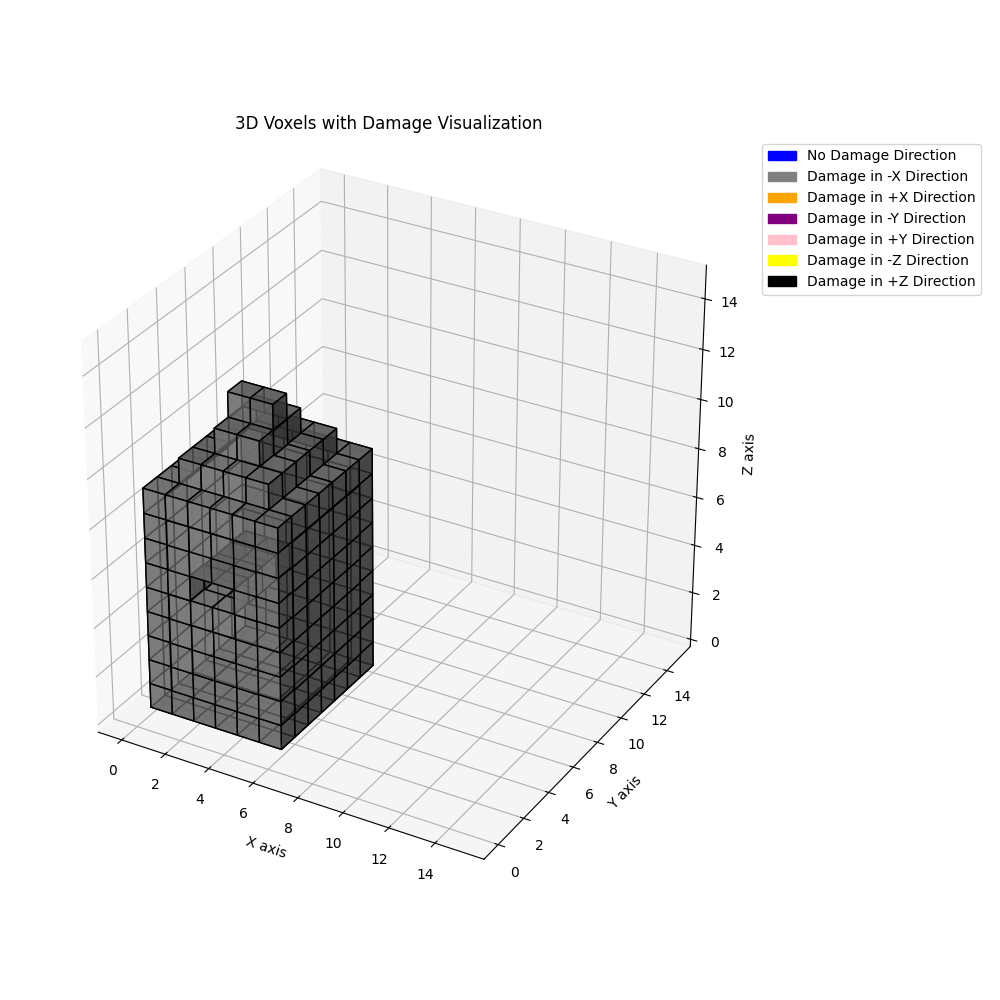

In [126]:
plot_voxels(shapes[471], shapes[471])

In [127]:
import torch
tensor_shape = torch.from_numpy(shapes[471]).unsqueeze(0)
initial_state = nca.initialize(tensor_shape)

In [128]:
state = initial_state * 1
with torch.no_grad():
    for i in range(128):
        state = nca(state)


In [129]:
state

tensor([[[[[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           ...,
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000]],

          [[   1.0000,   80.3193,   90.5964,  ..., -103.1794,  -98.8510,
             -49.1658],
           [   1.0000,  -87.8146,   70.3379,  ...,  -99.7110,  -96.2918,
             -61.8845],
           [   1.0000,  -88.6305,  -19.6850,  ...,  -98.4606,  -93.3860,
             -71.3940],
           ...,
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.000

In [130]:
classification = nca.classify(state)

In [131]:
np.unique(classification.argmax(dim=-1).squeeze(0).numpy(), return_counts=True)

(array([0, 1, 3, 6]), array([3182,  123,   69,    1]))

In [132]:
detached = classification.argmax(dim=-1).squeeze(0).numpy()

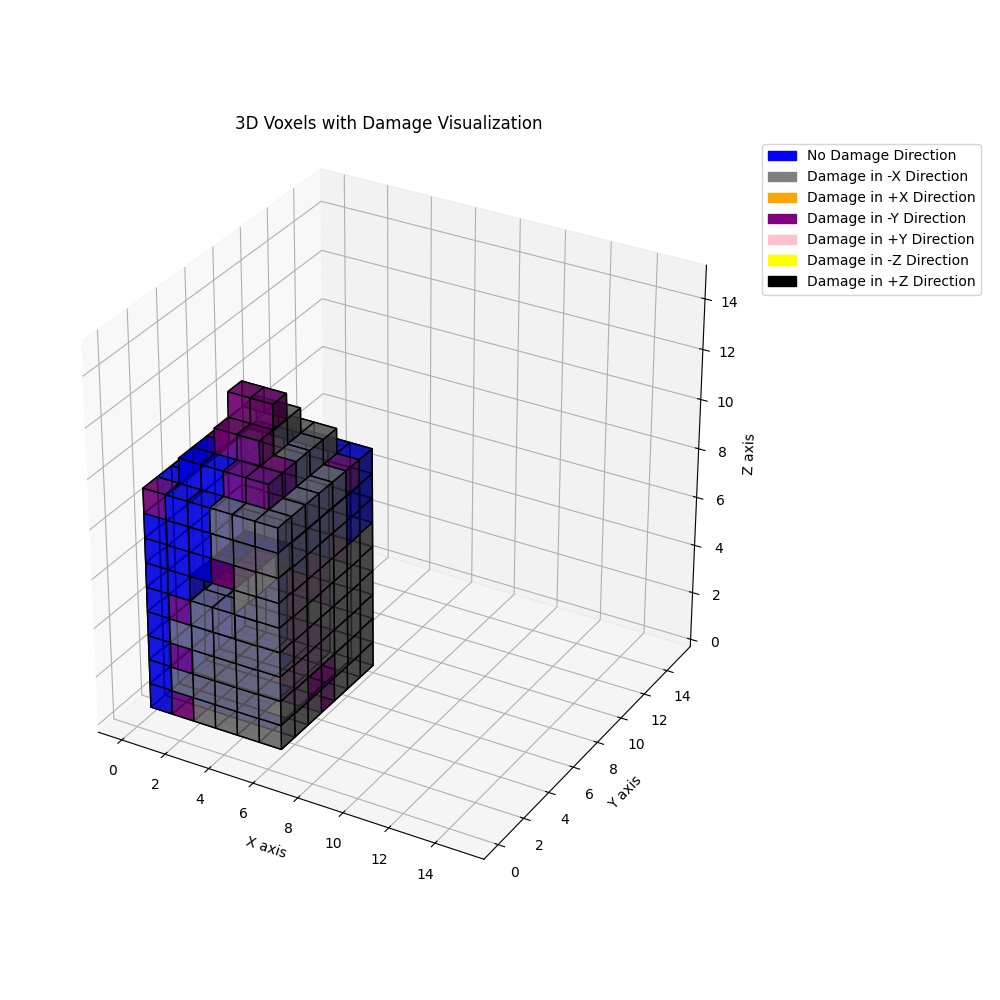

In [133]:
plot_voxels(shapes[471], detached)